In [1]:
## Initial Part


import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
#import fAux
import matplotlib.pyplot as plt
import seaborn as sns
import sys

np.random.seed() #to fix the results
 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
from datetime import datetime
import alphalens

from time import time
from pathlib import Path
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.svm import LinearSVC
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score
import talib as ta
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns
import re

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import TimeSeriesSplit

In [3]:
file_path = 'outputfile.txt'
sys.stdout = open(file_path, "w")

In [4]:
df_Gold = pd.read_csv('Gold Futures Historical Data.csv')

In [5]:
df_Crude = pd.read_csv('Crude Oil WTI Futures Historical Data.csv')

In [6]:
df = pd.read_csv('Try-3.csv')

In [7]:
df['DATE'] = pd.to_datetime(df['date'] )
df_Crude['DATE'] = pd.to_datetime(df_Crude['Date'] )
df_Gold['DATE'] = pd.to_datetime(df_Gold['Date'] )

In [8]:
df.set_index(["DATE"],inplace=True)
df.drop(['date'], axis=1, inplace=True)

df_Gold.set_index(["DATE"],inplace=True)
df_Gold.drop(['Date'], axis=1, inplace=True)

df_Crude.set_index(["DATE"],inplace=True)
df_Crude.drop(['Date'], axis=1, inplace=True)

In [9]:
df_Gold = df_Gold.iloc[::-1]
df_Crude = df_Crude.iloc[::-1]

In [10]:
Stock_name = df['symbol'].unique()

In [11]:
df_SandP = pd.read_csv('S&P 500 Historical Data.csv')
df_Nasdaq = pd.read_csv('Nasdaq Historical Data.csv')
df_DJIA = pd.read_csv('Dow Jones Industrial Average Historical Data.csv')

In [12]:
df_SandP['DATE'] = pd.to_datetime(df_SandP['Date'])
df_Nasdaq['DATE'] = pd.to_datetime(df_Nasdaq['Date'])
df_DJIA['DATE'] = pd.to_datetime(df_DJIA['Date'])
df_Nasdaq.rename(columns = {'Close':'Price'},inplace = True)

In [13]:
df_SandP.set_index(["DATE"],inplace=True)
df_Nasdaq.set_index(["DATE"],inplace=True)
df_DJIA.set_index(["DATE"],inplace=True)

In [14]:
df_SandP.drop(['Date'], axis=1, inplace=True)
df_Nasdaq.drop(['Date'], axis=1, inplace=True)
df_DJIA.drop(['Date'], axis=1, inplace=True)

In [15]:
df_SandP = df_SandP.iloc[::-1]
df_DJIA = df_DJIA.iloc[::-1]

In [16]:
df_SandP = df_SandP.astype(float, errors = 'ignore')
df_Nasdaq = df_Nasdaq.astype(float, errors = 'ignore')
df_DJIA = df_DJIA.astype(float, errors = 'ignore')

In [17]:
Aa = df['OPrice'].loc[df['symbol'] == Stock_name[0]]
Ag = df['OPrice'].loc[df['symbol'] == Stock_name[1]]
In = df['OPrice'].loc[df['symbol'] == Stock_name[2]]
Crude = df_Crude['Price']

df_Gold['Price'] = df_Gold['Price'].apply(lambda x: str(x.replace(',','')))
df_Gold['Price'] = df_Gold['Price'].astype(float, errors = 'ignore')
Gold = df_Gold['Price']


In [18]:
df_SandP = df_SandP.applymap(lambda x: str(x. replace(',','')))
df_DJIA = df_DJIA.applymap(lambda x: str(x. replace(',','')))


In [19]:
df_List = [df_SandP,df_Nasdaq,df_DJIA]

In [20]:
for column in Stock_name:
    df_Target = df['OPrice'].loc[df['symbol'] == column]
    for df_Feat in df_List:
        df_Feat['Price'] = df_Feat['Price'].astype(float, errors = 'ignore')
        df_Feat['Open'] = df_Feat['Open'].astype(float, errors = 'raise')
        df_Feat['Low'] = df_Feat['Low'].astype(float, errors = 'raise')
        df_Feat['High'] = df_Feat['High'].astype(float, errors = 'raise')


In [21]:
df_SandP = df_SandP.interpolate()
df_Nasdaq = df_Nasdaq.interpolate()
df_DJIA = df_DJIA.interpolate()

In [22]:
### Indicators ###
def simple_moving_average(df):
    df['SMA_5'] = df['Open'].transform(lambda x:x.rolling(window = 5).mean())
    df['SMA_15'] = df['Open'].transform(lambda x:x.rolling(window = 15).mean())
    df['SMA_30'] = df['Open'].transform(lambda x:x.rolling(window = 30).mean())
    df['SMA_60'] = df['Open'].transform(lambda x:x.rolling(window = 60).mean())

    df['SMA_ratio'] = df['SMA_60'] / df['SMA_5']
    
    return df

def MACD(df):
    df['ewm_15'] = df['Open'].transform(lambda x:x.ewm(span=15, adjust = False).mean())
    df['ewm_30'] = df['Open'].transform(lambda x:x.ewm(span=30, adjust = False).mean())
    df['MACD'] = df['ewm_30'] - df['ewm_15']
    return df

def stochastic_oscillators(df):
    df['LOWEST15D'] = df['Low'].transform(lambda x:x.rolling(window = 15).min())
    df['HIGHEST15D'] = df['High'].transform(lambda x:x.rolling(window = 15).max())
    
    df['LOWEST30D'] = df['Low'].transform(lambda x:x.rolling(window = 30).min())
    df['HIGHEST30D'] = df['High'].transform(lambda x:x.rolling(window = 30).max())

    df['Stochastic_15'] = ((df['Open'] - df['LOWEST15D'])/(df['HIGHEST15D'] - df['LOWEST15D']))*100
    df['Stochastic_30'] = ((df['Open'] - df['LOWEST30D'])/(df['HIGHEST30D'] - df['LOWEST30D']))*100
    
    df['Stochastic_%D_15'] = df['Stochastic_15'].rolling(window = 15).mean()
    df['Stochastic_%D_30'] = df['Stochastic_30'].rolling(window = 30).mean()
    
    df['Stochastic_Ratio'] = df['Stochastic_%D_15']/df['Stochastic_%D_30']
    return df

def ROC(df):
    df['RC_5'] = df['Open'].transform(lambda x: x.pct_change(periods = 5)) 
    df['RC_15'] = df['Open'].transform(lambda x: x.pct_change(periods = 15)) 
    df['RC_30'] = df['Open'].transform(lambda x: x.pct_change(periods = 30)) 
    df['RC_60'] = df['Open'].transform(lambda x: x.pct_change(periods = 60)) 
    return df

    
import talib as ta

def RSI(df):
    df['RSI_5']=ta.RSI(np.array(df['Open']), timeperiod=5)
    df['RSI_15']=ta.RSI(np.array(df['Open']), timeperiod=15)
    df['RSI_30']=ta.RSI(np.array(df['Open']), timeperiod=30)
    df['RSI_60']=ta.RSI(np.array(df['Open']), timeperiod=60)
    return df
    
def ADX(df):
    df['ADX_5']=ta.ADX(np.array(df['High']),np.array(df['Low']), np.array(df['Open']), timeperiod =5)
    df['ADX_15']=ta.ADX(np.array(df['High']),np.array(df['Low']), np.array(df['Open']), timeperiod =15)
    df['ADX_30']=ta.ADX(np.array(df['High']),np.array(df['Low']), np.array(df['Open']), timeperiod =30)
    df['ADX_60']=ta.ADX(np.array(df['High']),np.array(df['Low']), np.array(df['Open']), timeperiod =60)
    return df

    

In [23]:
for df_temp in [df_SandP,df_DJIA,df_Nasdaq]:
    df_temp = simple_moving_average(df_temp)
    df_temp = MACD(df_temp)
    df_temp = stochastic_oscillators(df_temp)
    df_temp = ADX(df_temp)
    df_temp = ROC(df_temp)
    df_temp = RSI(df_temp)
    

In [24]:
df_SandP = df_SandP.fillna(0)
df_Nasdaq = df_Nasdaq.fillna(0)
df_DJIA = df_DJIA.fillna(0)

In [25]:
for df_Feat in [df_SandP,df_DJIA,df_Nasdaq]:
    for i in Crude.index:
        if i in df_Feat.index:
            df_Feat.loc[i,'Crude'] = Crude.loc[i]

for df_Feat in [df_SandP,df_DJIA,df_Nasdaq]:
    for i in Gold.index:
        if i in df_Feat.index:
            df_Feat.loc[i,'Gold'] = Gold.loc[i]

In [26]:
for column in Stock_name:
    df_Target = df['OPrice'].loc[df['symbol'] == column]
    for df_Feat in [df_SandP,df_DJIA,df_Nasdaq]:
        for i in df_Target.index:
            df_Feat.loc[i,column] = df_Target.loc[i]

In [27]:
df_SandP = df_SandP.drop(['Change %','Vol.','AAPL'],axis = 1)
df_SandP = df_SandP[df_SandP.index < '2012-01-01'] 
df_SandP = df_SandP[df_SandP.index > '2001-01-01']


In [28]:
df_DJIA = df_DJIA.drop(['Change %','AAPL'],axis = 1)
df_DJIA = df_DJIA[df_DJIA.index < '2012-01-01']
df_DJIA = df_DJIA[df_DJIA.index > '2001-01-01']

In [29]:
df_Nasdaq = df_Nasdaq.drop(['AAPL'],axis = 1)
df_Nasdaq = df_Nasdaq[df_Nasdaq.index < '2012-01-01']
df_Nasdaq = df_Nasdaq[df_Nasdaq.index > '2001-01-01']

In [30]:
df_SandP = df_SandP.interpolate()
df_Nasdaq = df_Nasdaq.interpolate()
df_DJIA = df_DJIA.interpolate()

df_SandP = df_SandP.iloc[1:,:]
df_Nasdaq = df_Nasdaq.iloc[1:,:]

df_DJIA = df_DJIA.iloc[1:,:]

In [31]:
df_Nasdaq = df_Nasdaq.drop(["Volume","Adj Close"],axis=1)
df_DJIA = df_DJIA.drop(["Vol."],axis=1)

In [32]:
df_DJIA.shape

(2766, 37)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer 
from sklearn import preprocessing
#import phik
#from phik.report import plot_correlation_matrix
from scipy.special import ndtr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, f1_score, mean_squared_error as mse, mean_absolute_error as mae
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
#from mixed_naive_bayes import MixedNB
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor



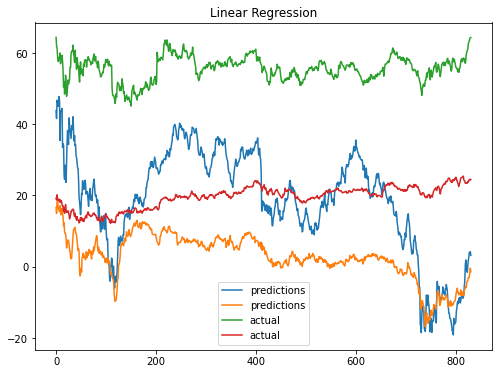

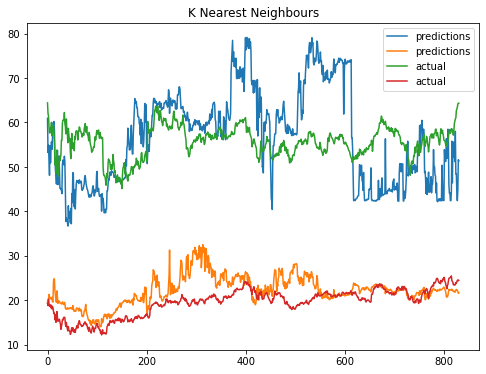

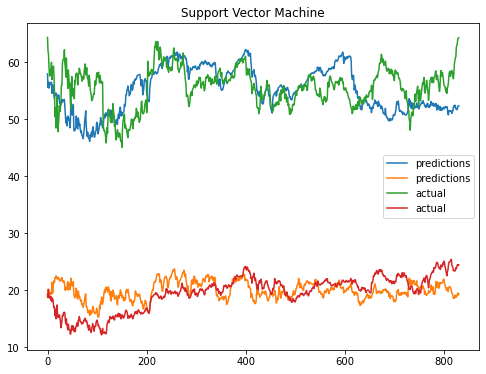

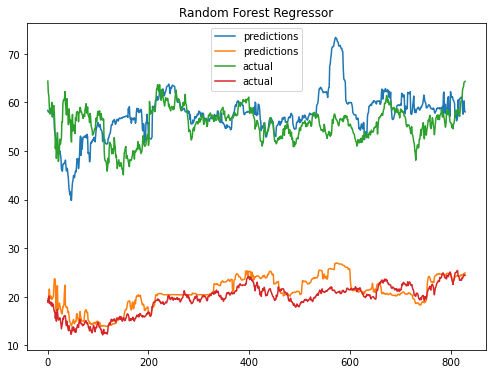

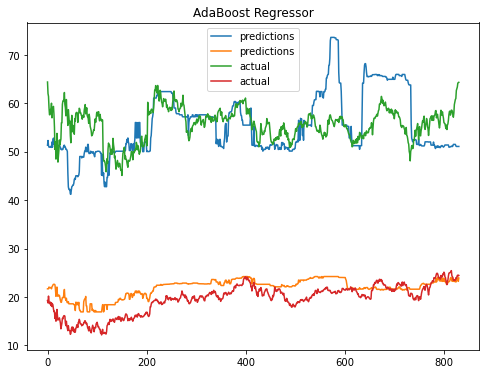

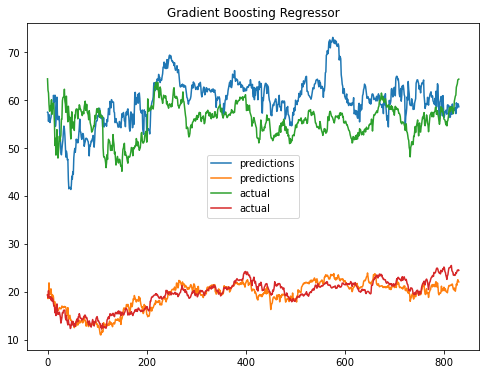

In [34]:
X = df_SandP.drop(['AMGN','INTC'], axis = 1)
y = df_SandP[['AMGN','INTC']]

X_train_SandP = X.iloc[0:round(0.7*(len(X.index)))]
X_test_SandP = X.iloc[round(0.7*(len(X.index))):]
y_train_SandP = y.iloc[0:round(0.7*(len(y.index)))]
y_test_SandP = y.iloc[round(0.7*(len(y.index))):]

training_error_SandP = []
test_error_SandP = []
# Creating Pipeline

#making numeric features
numeric_sub_pipeline = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_sub_pipeline, X_train_SandP.columns)],
         remainder='passthrough')

# Creating Regressor Objects
Regressor_lr =  LinearRegression()
Regressor_knn = KNeighborsRegressor()
Regressor_SVR = SVR()
Regressor_RFR = RandomForestRegressor()
Regressor_ABR = AdaBoostRegressor()
Regressor_GBR = GradientBoostingRegressor()

wrapper_lr = Regressor_lr
wrapper_knn = Regressor_knn
wrapper_SVR = MultiOutputRegressor(Regressor_SVR)
wrapper_RFR = MultiOutputRegressor(Regressor_RFR)
wrapper_ABR = MultiOutputRegressor(Regressor_ABR)
wrapper_GBR = MultiOutputRegressor(Regressor_GBR)

# Creating parameter grids for Models

c_rs = np.logspace(3,-4,num = 20, endpoint = True)
p_rs= ["l1", "l2"]

param_grid_lr =  {'regressor__fit_intercept': [True,False]}
param_grid_knn = {'regressor__n_neighbors':[i for i in range(2,12)]}
param_grid_svr = {'regressor__estimator__C':[1,2,3,5,10,15],'regressor__estimator__kernel': ['poly','rbf','linear','sigmoid'],'regressor__estimator__gamma':['scale','auto']}
param_grid_rfr = {'regressor__estimator__n_estimators':[70,100,150,200,300,500,800,1000]}
param_grid_abr = {'regressor__estimator__n_estimators':[50,100,150,300,500,600,800,1000],'regressor__estimator__learning_rate':[0.2,0.1,0.01,0.05,0.001,0.0001],'regressor__estimator__loss': ['linear','square','exponential']}
param_grid_gbr = {'regressor__estimator__n_estimators':[50,100,150,300,500,600,800,1000],'regressor__estimator__learning_rate':[0.2,0.1,0.01,0.05,0.001,0.0001]}

#Creating Model List
models_list = {'Linear Regression': (wrapper_lr, param_grid_lr),
               'K Nearest Neighbours': (wrapper_knn, param_grid_knn),
               'Support Vector Machine': (wrapper_SVR, param_grid_svr),
               'Random Forest Regressor': (wrapper_RFR, param_grid_rfr),
               'AdaBoost Regressor': (wrapper_ABR, param_grid_abr),
               'Gradient Boosting Regressor': (wrapper_GBR, param_grid_gbr)}

#Creating a model comparison function
def train_and_score_model(model_name, pipeline, model_info):
    
    grid_search = RandomizedSearchCV(pipeline, model_info, cv=5, return_train_score=True)
    grid_search.fit(X_train_SandP, y_train_SandP)
    best_parameters = grid_search.best_params_

    pred_y_train = grid_search.predict(X_train_SandP)
    pred_y_test = grid_search.predict(X_test_SandP)
    
    score_test = r2_score(y_test_SandP,pred_y_test)
    score_train = r2_score(y_train_SandP,pred_y_train)
    MSE_Score_test = mse(y_test_SandP,pred_y_test)
    MSE_Score_train = mse(y_train_SandP,pred_y_train)
    
    training_error_SandP.append(MSE_Score_train)
    test_error_SandP.append(MSE_Score_test)
    

    return pred_y_test,pred_y_train,score_test,score_train,MSE_Score_test,MSE_Score_train,best_parameters,model_name

cols= ['Test MSE','Train MSE','test_score','train_score','Best Parameters','Model Name']
lst = []
j = 0
for model_name, model_info in models_list.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor',model_info[0])])
    pred_value_test,pred_value_train,s_test,s_train,MSE_test,MSE_train,best_parameters,model_name = train_and_score_model(model_name, pipeline, model_info[1])
    lst.append([MSE_test,MSE_train,s_test,s_train,best_parameters,model_name])
    plt.figure(figsize=[20,10])
    plt.subplot(2,3,(j+1))
    plt.title(model_name)
    plt.plot(pred_value_test, label = "predictions")
    plt.plot(y_test_SandP.to_numpy(), label = "actual")
    plt.legend()
    plt.tight_layout()
    j = j+1
plt.show()
data = pd.DataFrame(lst,columns = cols)
data = data.set_index('Model Name')

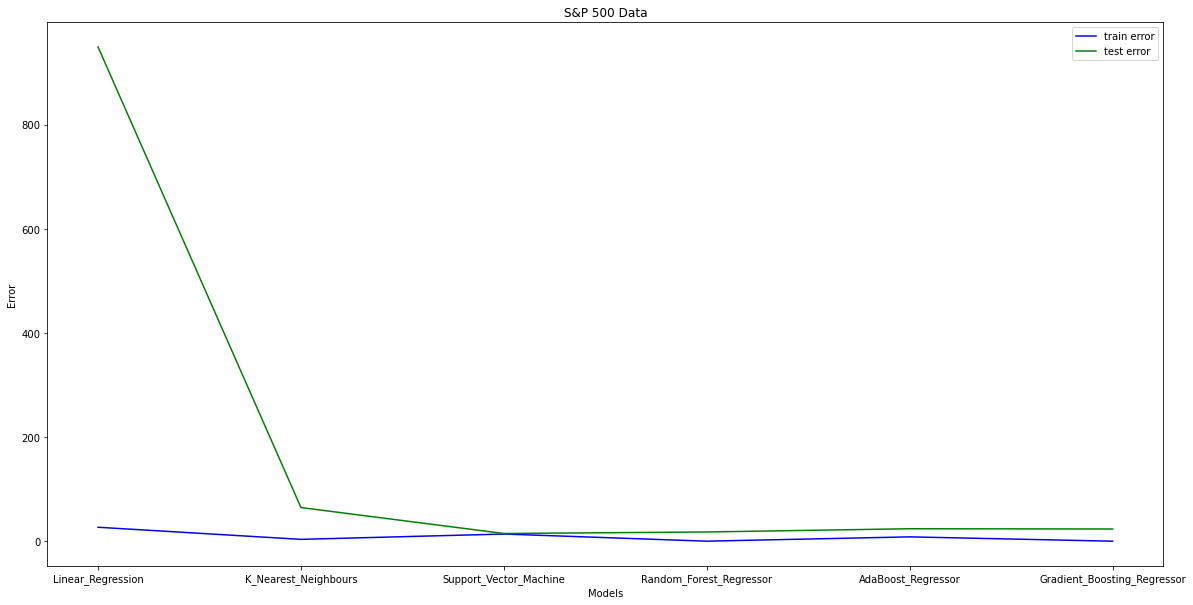

In [35]:
plt.figure(figsize=[20,10])
x=[0,1,2,3,4,5]
values=['Linear_Regression', 'K_Nearest_Neighbours','Support_Vector_Machine','Random_Forest_Regressor','AdaBoost_Regressor','Gradient_Boosting_Regressor']
plt.title('S&P 500 Data')
plt.plot(training_error_SandP,  color='blue', label='train error')
plt.plot(test_error_SandP, color='green', label='test error')
plt.ylabel("Error")
plt.xlabel("Models")
plt.xticks(x,values)
plt.legend()
plt.show()

In [36]:
data.to_csv('SandP_best_models.csv')

In [37]:
data

Test MSE  Train MSE  test_score  train_score  \
Model Name                                                                    
Linear Regression            948.911123  26.851086  -83.310918     0.512741   
K Nearest Neighbours          64.663884   3.604861   -4.666787     0.942476   
Support Vector Machine        14.831030  13.798790   -0.357800     0.795476   
Random Forest Regressor       17.766976   0.110824   -0.566760     0.998058   
AdaBoost Regressor            23.963803   8.378450   -1.132427     0.872776   
Gradient Boosting Regressor   23.483860   0.088543   -1.018962     0.998535   

                                                               Best Parameters  
Model Name                                                                      
Linear Regression                           {'regressor__fit_intercept': True}  
K Nearest Neighbours                            {'regressor__n_neighbors': 11}  
Support Vector Machine       {'regressor__estimator__kernel': 'rbf', 'regre...  
Random Forest Regressor            {'regressor__estimator__n_estimators': 800}  
AdaBoost Regressor           {'regressor__estimator__n_estimators': 150, 'r...  
Gradient Boosting Regressor  {'regressor__estimator__n_estimators': 800, 'r...

In [38]:
df_1 = pd.DataFrame(pred_value_test, columns=["AMGN_SandP","INTC_SandP"],index = X_test_SandP.index)

In [39]:
MAE_Score_test = mae(y_test_SandP.iloc[:,1],pred_value_test[:,1])
MAE_Score_train = mae(y_train_SandP.iloc[:,1],pred_value_train[:,1])

In [40]:
MAE_Score_test

1.3435622226385213

In [41]:
MAE_Score_train

0.13775523387873498

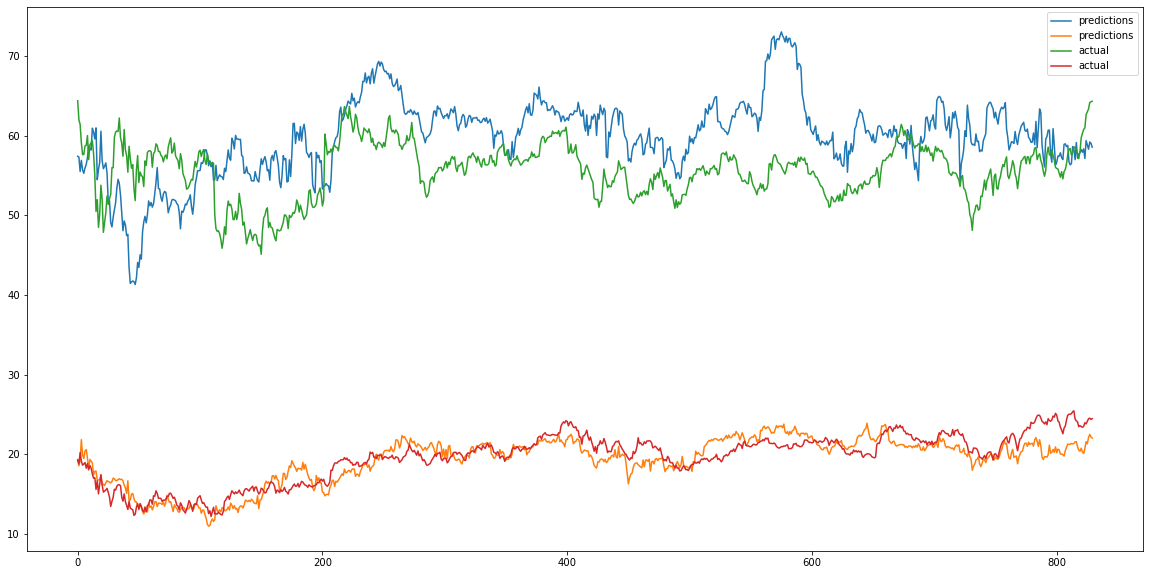

In [42]:
plt.figure(figsize=[20,10])
plt.plot(pred_value_test, label = "predictions")
plt.plot(y_test_SandP.to_numpy(), label = "actual")
plt.legend()
plt.show()

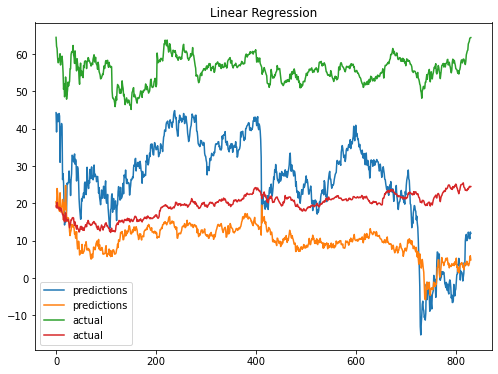

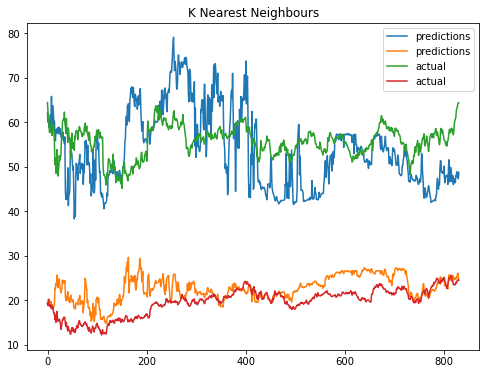

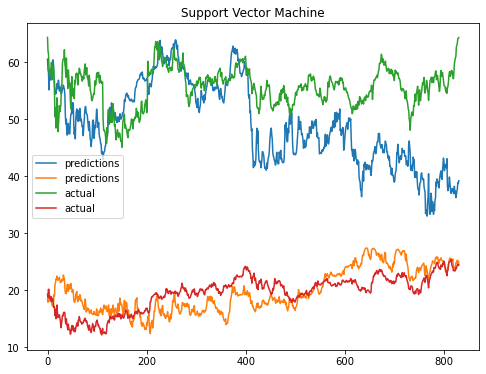

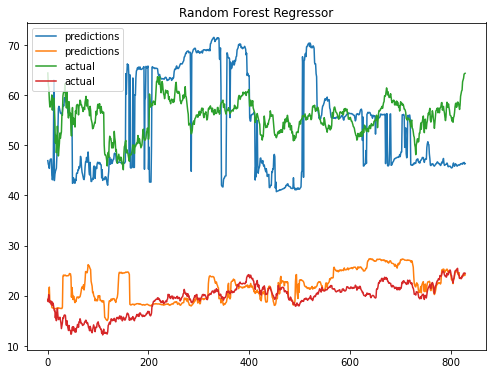

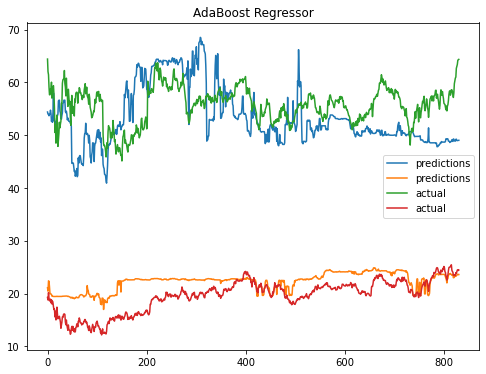

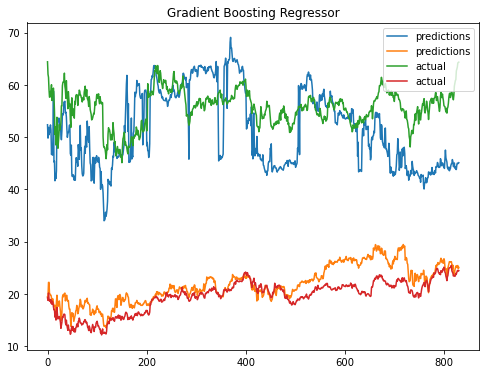

In [43]:
X = df_Nasdaq.drop(['AMGN','INTC'], axis = 1)
y = df_Nasdaq[['AMGN','INTC']]

X_train_Nasdaq = X.iloc[0:round(0.7*(len(X.index)))]
X_test_Nasdaq = X.iloc[round(0.7*(len(X.index))):]
y_train_Nasdaq = y.iloc[0:round(0.7*(len(y.index)))]
y_test_Nasdaq = y.iloc[round(0.7*(len(y.index))):]

training_error_Nasdaq = []
test_error_Nasdaq = []

# Creating Pipeline

#making numeric features
numeric_sub_pipeline = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_sub_pipeline, X_train_Nasdaq.columns)],
         remainder='passthrough')

# Creating Regressor Objects
Regressor_lr =  LinearRegression()
Regressor_knn = KNeighborsRegressor()
Regressor_SVR = SVR()
Regressor_RFR = RandomForestRegressor()
Regressor_ABR = AdaBoostRegressor()
Regressor_GBR = GradientBoostingRegressor()

wrapper_lr = Regressor_lr
wrapper_knn = Regressor_knn
wrapper_SVR = MultiOutputRegressor(Regressor_SVR)
wrapper_RFR = MultiOutputRegressor(Regressor_RFR)
wrapper_ABR = MultiOutputRegressor(Regressor_ABR)
wrapper_GBR = MultiOutputRegressor(Regressor_GBR)

# Creating parameter grids for Models

c_rs = np.logspace(3,-4,num = 20, endpoint = True)
p_rs= ["l1", "l2"]

param_grid_lr =  {'regressor__fit_intercept': [True,False]}
param_grid_knn = {'regressor__n_neighbors':[i for i in range(2,12)]}
param_grid_svr = {'regressor__estimator__C':[1,2,3,5,10,15],'regressor__estimator__kernel': ['poly','rbf','linear','sigmoid'],'regressor__estimator__gamma':['scale','auto']}
param_grid_rfr = {'regressor__estimator__n_estimators':[70,100,150,200,300,500,800,1000]}
param_grid_abr = {'regressor__estimator__n_estimators':[50,100,150,300,500,600,800,1000],'regressor__estimator__learning_rate':[0.2,0.1,0.01,0.05,0.001,0.0001],'regressor__estimator__loss': ['linear','square','exponential']}
param_grid_gbr = {'regressor__estimator__n_estimators':[50,100,150,300,500,600,800,1000],'regressor__estimator__learning_rate':[0.2,0.1,0.01,0.05,0.001,0.0001]}

#Creating Model List
models_list = {'Linear Regression': (wrapper_lr, param_grid_lr),
               'K Nearest Neighbours': (wrapper_knn, param_grid_knn),
               'Support Vector Machine': (wrapper_SVR, param_grid_svr),
               'Random Forest Regressor': (wrapper_RFR, param_grid_rfr),
               'AdaBoost Regressor': (wrapper_ABR, param_grid_abr),
               'Gradient Boosting Regressor': (wrapper_GBR, param_grid_gbr)}

#Creating a model comparison function
def train_and_score_model(model_name, pipeline, model_info):
    
    grid_search = RandomizedSearchCV(pipeline, model_info, cv=5, return_train_score=True)
    grid_search.fit(X_train_Nasdaq, y_train_Nasdaq)
    best_parameters = grid_search.best_params_

    pred_y_train = grid_search.predict(X_train_Nasdaq)
    pred_y_test = grid_search.predict(X_test_Nasdaq)
    
    score_test = r2_score(y_test_Nasdaq,pred_y_test)
    score_train = r2_score(y_train_Nasdaq,pred_y_train)
    MSE_Score_test = mse(y_test_Nasdaq,pred_y_test)
    MSE_Score_train = mse(y_train_Nasdaq,pred_y_train)
    
    training_error_Nasdaq.append(MSE_Score_train)
    test_error_Nasdaq.append(MSE_Score_test)

    return pred_y_test,pred_y_train,score_test,score_train,MSE_Score_test,MSE_Score_train,best_parameters,model_name

cols= ['Test MSE','Train MSE','test_score','train_score','Best Parameters','Model Name']
lst = []
j = 0
for model_name, model_info in models_list.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor',model_info[0])])
    pred_value_test,pred_value_train,s_test,s_train,MSE_test,MSE_train,best_parameters,model_name = train_and_score_model(model_name, pipeline, model_info[1])
    lst.append([MSE_test,MSE_train,s_test,s_train,best_parameters,model_name])
    plt.figure(figsize=[20,10])
    plt.subplot(2,3,(j+1))
    plt.title(model_name)
    plt.plot(pred_value_test, label = "predictions")
    plt.plot(y_test_Nasdaq.to_numpy(), label = "actual")
    plt.legend()
    plt.tight_layout()
    j = j+1
plt.show()
data = pd.DataFrame(lst,columns = cols)
data = data.set_index('Model Name')


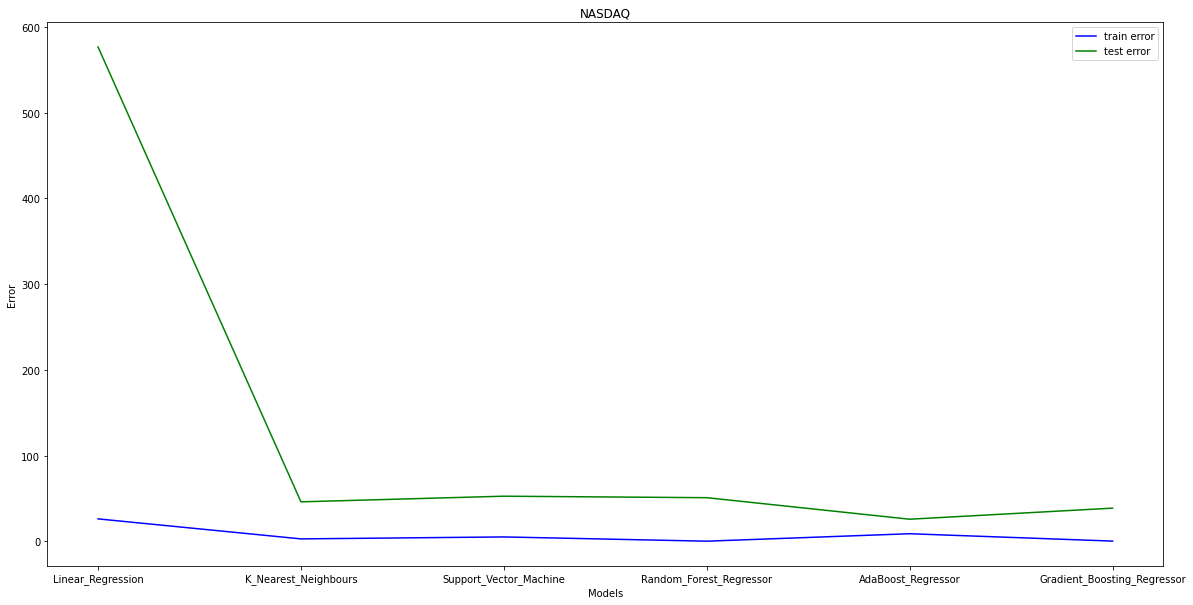

In [44]:
plt.figure(figsize=[20,10])
x=[0,1,2,3,4,5]
values=['Linear_Regression', 'K_Nearest_Neighbours','Support_Vector_Machine','Random_Forest_Regressor','AdaBoost_Regressor','Gradient_Boosting_Regressor']
plt.title('NASDAQ')
plt.plot(training_error_Nasdaq,  color='blue', label='train error')
plt.plot(test_error_Nasdaq, color='green', label='test error')
plt.ylabel("Error")
plt.xlabel("Models")
plt.xticks(x,values)
plt.legend()
plt.show()

In [45]:
data.to_csv('Nasdaq_best_models.csv')

In [46]:
data

Test MSE  Train MSE  test_score  train_score  \
Model Name                                                                    
Linear Regression            576.772008  26.148351  -49.227451     0.579895   
K Nearest Neighbours          46.051160   2.815376   -3.104591     0.953865   
Support Vector Machine        52.627339   5.095443   -3.577495     0.935191   
Random Forest Regressor       50.886781   0.134557   -3.481597     0.998096   
AdaBoost Regressor            25.768442   8.828833   -1.322615     0.863741   
Gradient Boosting Regressor   38.689257   0.239420   -2.381645     0.996634   

                                                               Best Parameters  
Model Name                                                                      
Linear Regression                           {'regressor__fit_intercept': True}  
K Nearest Neighbours                            {'regressor__n_neighbors': 11}  
Support Vector Machine       {'regressor__estimator__kernel': 'rbf', 'regre...  
Random Forest Regressor            {'regressor__estimator__n_estimators': 800}  
AdaBoost Regressor           {'regressor__estimator__n_estimators': 600, 'r...  
Gradient Boosting Regressor  {'regressor__estimator__n_estimators': 1000, '...

In [47]:
df_2 = pd.DataFrame(pred_value_test, columns=["AMGN_Nasdaq","INTC_Nasdaq"],index = X_test_Nasdaq.index)

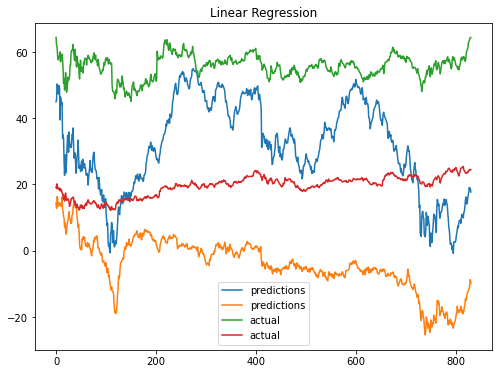

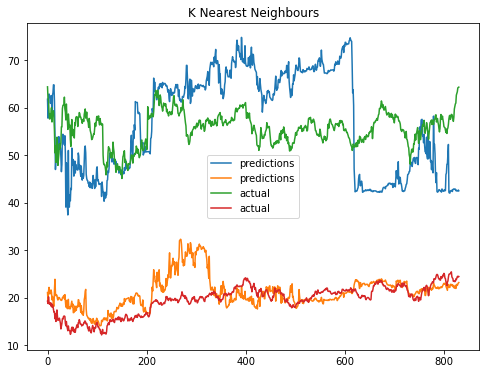

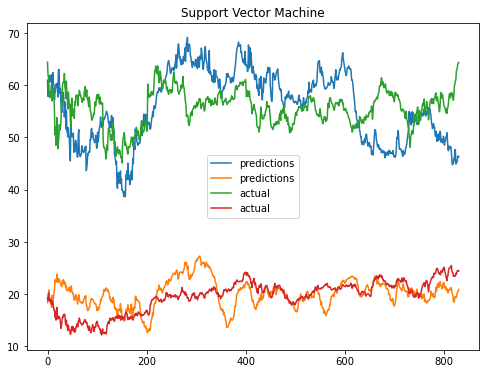

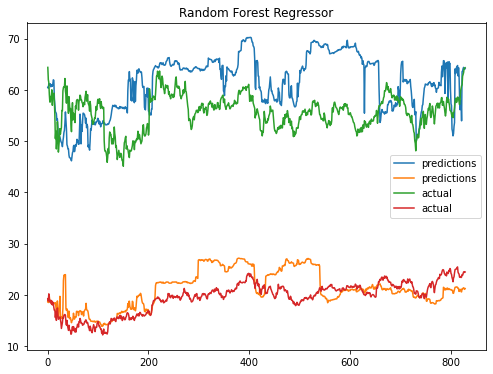

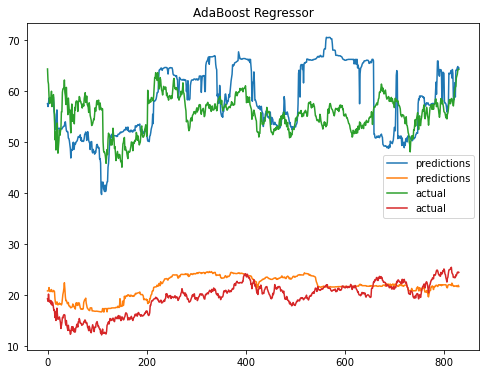

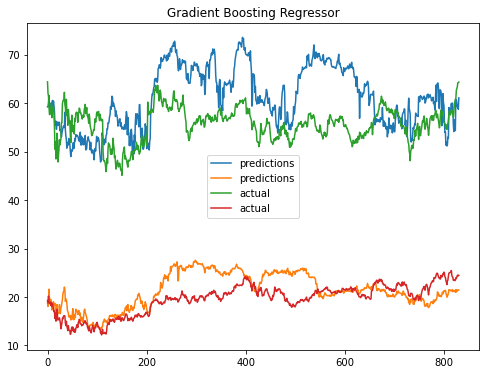

In [48]:
X = df_DJIA.drop(['AMGN','INTC'], axis = 1)
y = df_DJIA[['AMGN','INTC']]

X_train_DJIA = X.iloc[0:round(0.7*(len(X.index)))]
X_test_DJIA = X.iloc[round(0.7*(len(X.index))):]
y_train_DJIA = y.iloc[0:round(0.7*(len(y.index)))]
y_test_DJIA = y.iloc[round(0.7*(len(y.index))):]

training_error_DJIA = []
test_error_DJIA = []

# Creating Pipeline

#making numeric features
numeric_sub_pipeline = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_sub_pipeline, X_train_DJIA.columns)],
         remainder='passthrough')

# Creating Regressor Objects
Regressor_lr =  LinearRegression()
Regressor_knn = KNeighborsRegressor()
Regressor_SVR = SVR()
Regressor_RFR = RandomForestRegressor()
Regressor_ABR = AdaBoostRegressor()
Regressor_GBR = GradientBoostingRegressor()

wrapper_lr = Regressor_lr
wrapper_knn = Regressor_knn
wrapper_SVR = MultiOutputRegressor(Regressor_SVR)
wrapper_RFR = MultiOutputRegressor(Regressor_RFR)
wrapper_ABR = MultiOutputRegressor(Regressor_ABR)
wrapper_GBR = MultiOutputRegressor(Regressor_GBR)

# Creating parameter grids for Models

c_rs = np.logspace(3,-4,num = 20, endpoint = True)
p_rs= ["l1", "l2"]

param_grid_lr =  {'regressor__fit_intercept': [True,False]}
param_grid_knn = {'regressor__n_neighbors':[i for i in range(2,12)]}
param_grid_svr = {'regressor__estimator__C':[1,2,3,5,10,15],'regressor__estimator__kernel': ['poly','rbf','linear','sigmoid'],'regressor__estimator__gamma':['scale','auto']}
param_grid_rfr = {'regressor__estimator__n_estimators':[70,100,150,200,300,500,800,1000]}
param_grid_abr = {'regressor__estimator__n_estimators':[50,100,150,300,500,600,800,1000],'regressor__estimator__learning_rate':[0.2,0.1,0.01,0.05,0.001,0.0001],'regressor__estimator__loss': ['linear','square','exponential']}
param_grid_gbr = {'regressor__estimator__n_estimators':[50,100,150,300,500,600,800,1000],'regressor__estimator__learning_rate':[0.2,0.1,0.01,0.05,0.001,0.0001]}

#Creating Model List
models_list = {'Linear Regression': (wrapper_lr, param_grid_lr),
               'K Nearest Neighbours': (wrapper_knn, param_grid_knn),
               'Support Vector Machine': (wrapper_SVR, param_grid_svr),
               'Random Forest Regressor': (wrapper_RFR, param_grid_rfr),
               'AdaBoost Regressor': (wrapper_ABR, param_grid_abr),
               'Gradient Boosting Regressor': (wrapper_GBR, param_grid_gbr)}

#Creating a model comparison function
def train_and_score_model(model_name, pipeline, model_info):
    
    grid_search = RandomizedSearchCV(pipeline, model_info, cv=5, return_train_score=True)
    grid_search.fit(X_train_DJIA , y_train_DJIA)
    best_parameters = grid_search.best_params_

    pred_y_train = grid_search.predict(X_train_DJIA)
    pred_y_test = grid_search.predict(X_test_DJIA)
    
    score_test = r2_score(y_test_DJIA,pred_y_test)
    score_train = r2_score(y_train_DJIA,pred_y_train)
    MSE_Score_test = mse(y_test_DJIA,pred_y_test)
    MSE_Score_train = mse(y_train_DJIA,pred_y_train)

    training_error_DJIA.append(MSE_Score_train)
    test_error_DJIA.append(MSE_Score_test)
    
    return pred_y_test,pred_y_train,score_test,score_train,MSE_Score_test,MSE_Score_train,best_parameters,model_name

cols= ['Test MSE','Train MSE','test_score','train_score','Best Parameters','Model Name']
lst = []
j = 0
for model_name, model_info in models_list.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor',model_info[0])])
    pred_value_test,pred_value_train,s_test,s_train,MSE_test,MSE_train,best_parameters,model_name = train_and_score_model(model_name, pipeline, model_info[1])
    lst.append([MSE_test,MSE_train,s_test,s_train,best_parameters,model_name])
    plt.figure(figsize=[20,10])
    plt.subplot(2,3,(j+1))
    plt.title(model_name)
    plt.plot(pred_value_test, label = "predictions")
    plt.plot(y_test_DJIA.to_numpy(), label = "actual")
    plt.legend()
    plt.tight_layout()
    j = j+1
plt.show()
data = pd.DataFrame(lst,columns = cols)
data = data.set_index('Model Name')


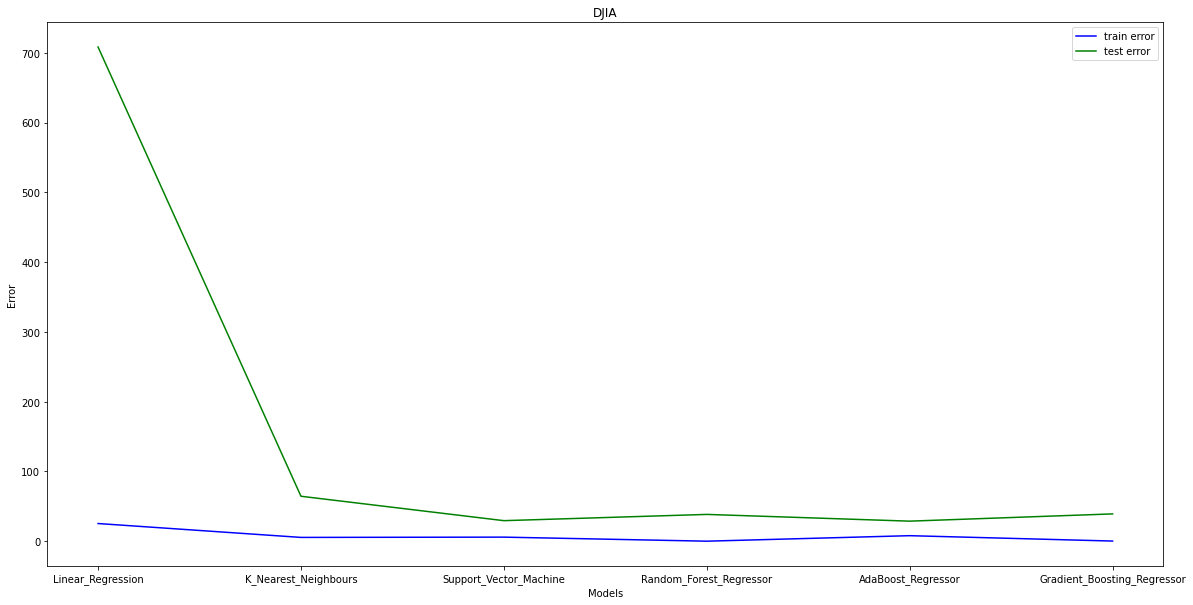

In [49]:
plt.figure(figsize=[20,10])
x=[0,1,2,3,4,5]
values=['Linear_Regression', 'K_Nearest_Neighbours','Support_Vector_Machine','Random_Forest_Regressor','AdaBoost_Regressor','Gradient_Boosting_Regressor']
plt.title('DJIA')
plt.plot(training_error_DJIA,  color='blue', label='train error')
plt.plot(test_error_DJIA, color='green', label='test error')
plt.ylabel("Error")
plt.xlabel("Models")
plt.xticks(x,values)
plt.legend()
plt.show()

In [50]:
MAE_Score_test = mae(y_test_DJIA.iloc[:,1],pred_value_test[:,1])
MAE_Score_train = mae(y_train_DJIA.iloc[:,1],pred_value_train[:,1])

In [51]:
MAE_Score_train

0.24725440673024462

In [52]:
MAE_Score_test

2.852796442561659

In [53]:
data.to_csv('DJIA_best_models.csv')

In [54]:
data

Test MSE  Train MSE  test_score  train_score  \
Model Name                                                                    
Linear Regression            708.230913  25.436376  -66.610417     0.547924   
K Nearest Neighbours          64.510605   5.548199   -4.620017     0.919196   
Support Vector Machine        29.542321   5.942461   -1.639939     0.916752   
Random Forest Regressor       38.508466   0.138989   -2.403898     0.997779   
AdaBoost Regressor            28.843259   8.024766   -1.546408     0.875441   
Gradient Boosting Regressor   39.233662   0.320970   -2.470068     0.994933   

                                                               Best Parameters  
Model Name                                                                      
Linear Regression                           {'regressor__fit_intercept': True}  
K Nearest Neighbours                            {'regressor__n_neighbors': 11}  
Support Vector Machine       {'regressor__estimator__kernel': 'rbf', 'regre...  
Random Forest Regressor            {'regressor__estimator__n_estimators': 200}  
AdaBoost Regressor           {'regressor__estimator__n_estimators': 500, 'r...  
Gradient Boosting Regressor  {'regressor__estimator__n_estimators': 800, 'r...

In [55]:
df_3 = pd.DataFrame(pred_value_test, columns=["AMGN_DJIA","INTC_DJIA"],index = X_test_DJIA.index)

In [57]:
price = pd.concat([df_1,df_2,df_3],axis = 1)

In [58]:
factor = price.stack()

In [60]:
alpha_data = get_clean_factor_and_forward_returns(factor = factor,
                                                    prices = price,
                                                    quantiles=5,
                                                    periods=(1, 5, 15, 30, 60),
                                                    max_loss = 60)

In [61]:
alpha_data.info()

min        max       mean       std  count    count %
factor_quantile                                                             
1                10.959756  23.894967  19.435044  2.719507   1540  33.333333
2                14.623081  29.461533  23.265948  3.690763    770  16.666667
3                34.008366  65.061293  51.518663  7.140441    770  16.666667
4                43.465390  70.100219  59.118408  4.971052    770  16.666667
5                48.979722  73.582409  62.430535  5.765931    770  16.666667

1D      5D     15D     30D  \
Ann. alpha                                     -0.114  -0.076  -0.064  -0.061   
beta                                           -0.022   0.022  -0.014  -0.065   
Mean Period Wise Return Top Quantile (bps)    -28.109 -17.930 -12.851 -10.756   
Mean Period Wise Return Bottom Quantile (bps)   6.876   5.073   3.677   4.097   
Mean Period Wise Spread (bps)                 -34.984 -23.479 -16.945 -15.371   

                                                  60D  
Ann. alpha                                     -0.051  
beta                                           -0.112  
Mean Period Wise Return Top Quantile (bps)     -7.342  
Mean Period Wise Return Bottom Quantile (bps)   3.409  
Mean Period Wise Spread (bps)                 -11.049

1D     5D    15D    30D     60D
IC Mean          -0.040 -0.069 -0.109 -0.151  -0.204
IC Std.           0.483  0.467  0.448  0.429   0.460
Risk-Adjusted IC -0.083 -0.148 -0.242 -0.351  -0.444
t-stat(IC)       -2.315 -4.110 -6.722 -9.744 -12.315
p-value(IC)       0.021  0.000  0.000  0.000   0.000
IC Skew           0.144  0.090  0.238  0.334   0.342
IC Kurtosis      -0.963 -0.886 -0.836 -0.570  -0.829

1D     5D    15D    30D    60D
Quantile 1 Mean Turnover   0.025  0.054  0.082  0.107  0.112
Quantile 2 Mean Turnover   0.049  0.107  0.164  0.214  0.224
Quantile 3 Mean Turnover   0.068  0.153  0.216  0.293  0.323
Quantile 4 Mean Turnover   0.183  0.324  0.445  0.586  0.623
Quantile 5 Mean Turnover   0.134  0.241  0.347  0.464  0.554

1D     5D    15D    30D    60D
Mean Factor Rank Autocorrelation  0.979  0.955  0.933  0.909  0.892

<Figure size 432x288 with 0 Axes>

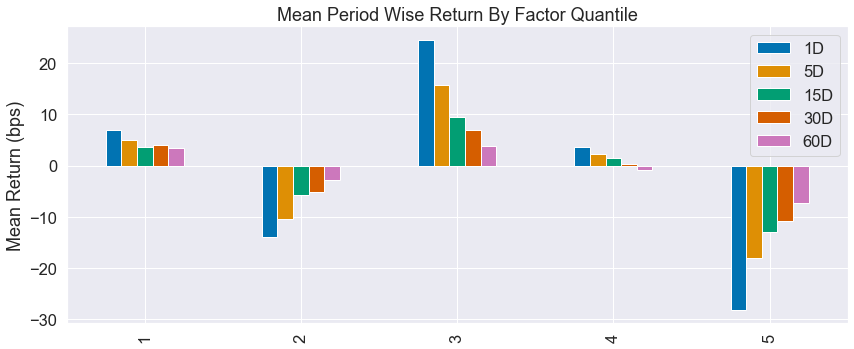

In [62]:
create_summary_tear_sheet(alpha_data)

In [63]:
alpha_data.head(15)

1D        5D       15D       30D       60D  \
date       asset                                                           
2008-09-17 AMGN_SandP  -0.001850 -0.037336  0.061997 -0.117062 -0.101237   
           INTC_SandP  -0.040391  0.006656 -0.075121 -0.125898 -0.301231   
           AMGN_Nasdaq -0.048836 -0.010388 -0.204662  0.040414 -0.127698   
           INTC_Nasdaq  0.004419  0.025970 -0.084903 -0.006517 -0.111450   
           AMGN_DJIA    0.000287 -0.000462 -0.064107 -0.081965 -0.099126   
           INTC_DJIA   -0.032797  0.019482  0.000332  0.041238 -0.084503   
2008-09-18 AMGN_SandP  -0.031551 -0.023795 -0.049655 -0.100254 -0.109761   
           INTC_SandP   0.035702  0.100405 -0.096615 -0.099666 -0.298687   
           AMGN_Nasdaq  0.041172  0.050644 -0.138659  0.088038 -0.108099   
           INTC_Nasdaq  0.134211  0.010897 -0.115898  0.013492 -0.171038   
           AMGN_DJIA    0.015076 -0.013870 -0.057131 -0.074643 -0.102477   
           INTC_DJIA    0.064622  0.080834 -0.095499  0.144546 -0.091462   
2008-09-19 AMGN_SandP   0.025132  0.015826  0.004714 -0.037981 -0.073065   
           INTC_SandP   0.136694  0.071976 -0.127314 -0.132733 -0.301474   
           AMGN_Nasdaq -0.027158 -0.009953 -0.188555  0.055163 -0.063572   

                           factor  factor_quantile  
date       asset                                    
2008-09-17 AMGN_SandP   57.437097                4  
           INTC_SandP   19.317353                1  
           AMGN_Nasdaq  52.370642                3  
           INTC_Nasdaq  19.488663                2  
           AMGN_DJIA    59.242060                5  
           INTC_DJIA    18.668163                1  
2008-09-18 AMGN_SandP   57.330818                4  
           INTC_SandP   18.537106                1  
           AMGN_Nasdaq  49.813085                3  
           INTC_Nasdaq  19.574788                2  
           AMGN_DJIA    59.259091                5  
           INTC_DJIA    18.055896                1  
2008-09-19 AMGN_SandP   55.521961                4  
           INTC_SandP   19.198916                1  
           AMGN_Nasdaq  51.864004                3

min        max       mean       std  count    count %
factor_quantile                                                             
1                10.959756  23.894967  19.435044  2.719507   1540  33.333333
2                14.623081  29.461533  23.265948  3.690763    770  16.666667
3                34.008366  65.061293  51.518663  7.140441    770  16.666667
4                43.465390  70.100219  59.118408  4.971052    770  16.666667
5                48.979722  73.582409  62.430535  5.765931    770  16.666667

1D      5D     15D     30D  \
Ann. alpha                                     -0.114  -0.076  -0.064  -0.061   
beta                                           -0.022   0.022  -0.014  -0.065   
Mean Period Wise Return Top Quantile (bps)    -28.109 -17.930 -12.851 -10.756   
Mean Period Wise Return Bottom Quantile (bps)   6.876   5.073   3.677   4.097   
Mean Period Wise Spread (bps)                 -34.984 -23.479 -16.945 -15.371   

                                                  60D  
Ann. alpha                                     -0.051  
beta                                           -0.112  
Mean Period Wise Return Top Quantile (bps)     -7.342  
Mean Period Wise Return Bottom Quantile (bps)   3.409  
Mean Period Wise Spread (bps)                 -11.049

<Figure size 432x288 with 0 Axes>

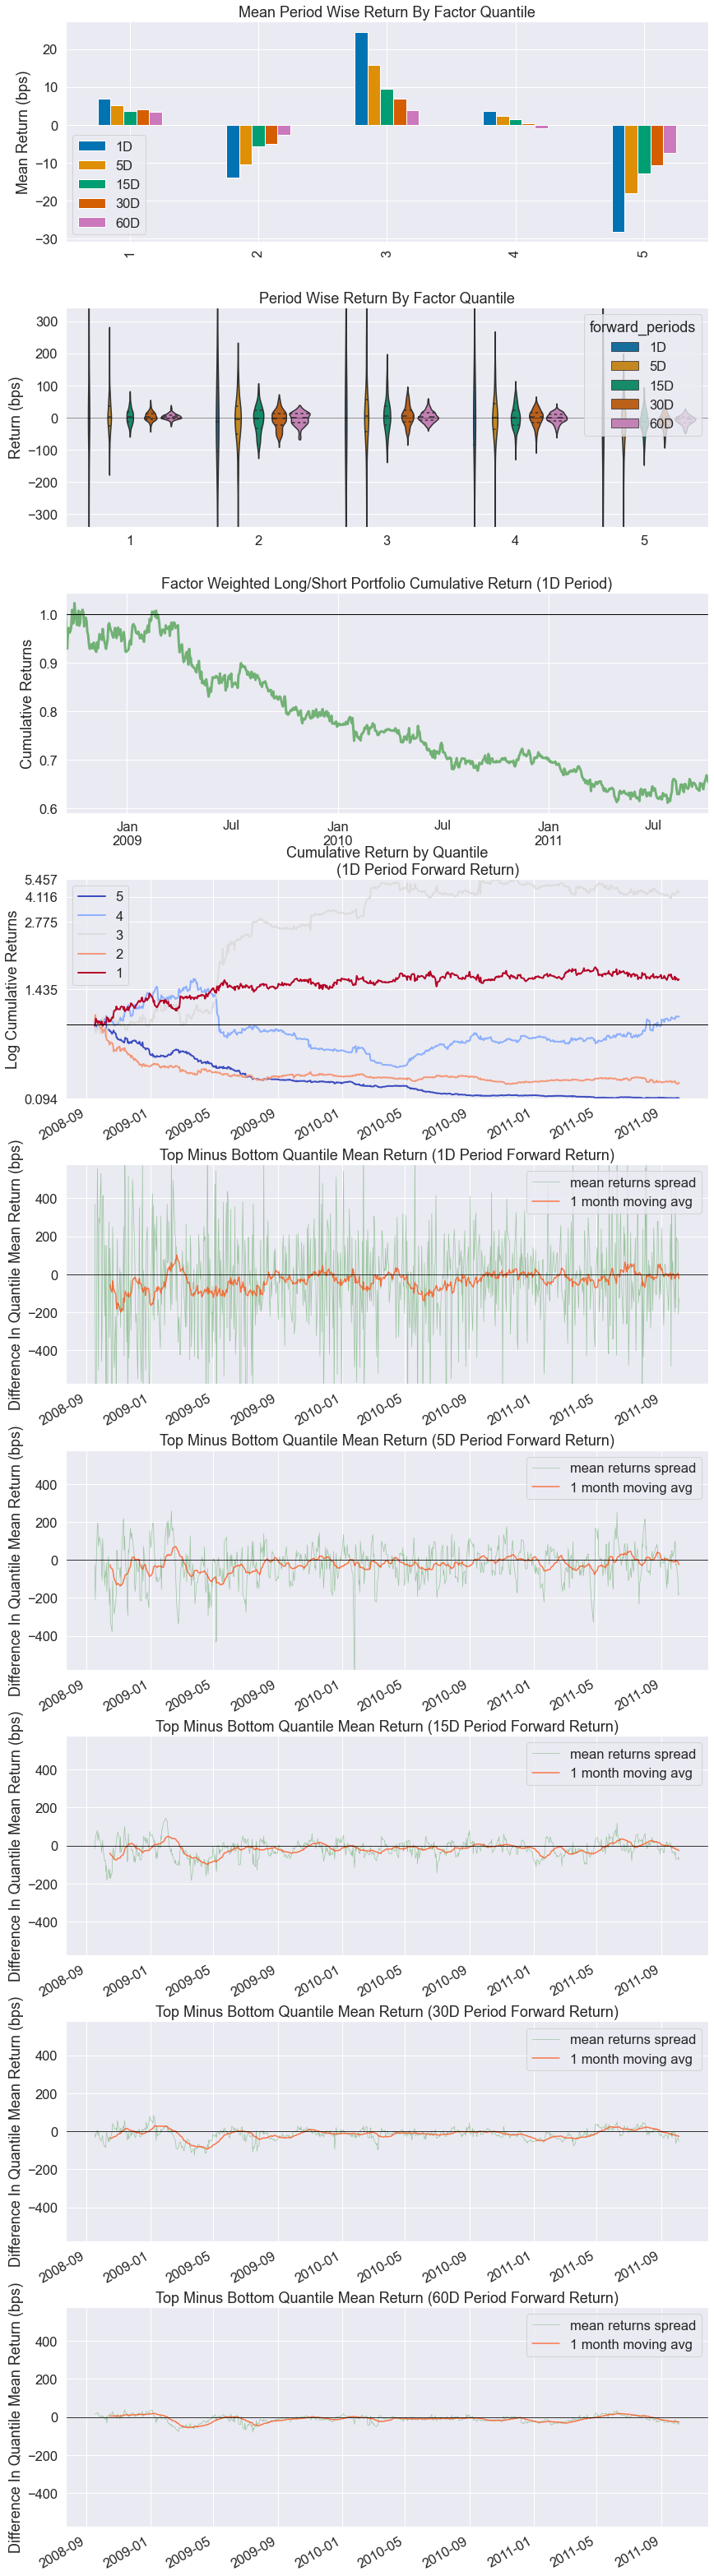

1D     5D    15D    30D     60D
IC Mean          -0.040 -0.069 -0.109 -0.151  -0.204
IC Std.           0.483  0.467  0.448  0.429   0.460
Risk-Adjusted IC -0.083 -0.148 -0.242 -0.351  -0.444
t-stat(IC)       -2.315 -4.110 -6.722 -9.744 -12.315
p-value(IC)       0.021  0.000  0.000  0.000   0.000
IC Skew           0.144  0.090  0.238  0.334   0.342
IC Kurtosis      -0.963 -0.886 -0.836 -0.570  -0.829

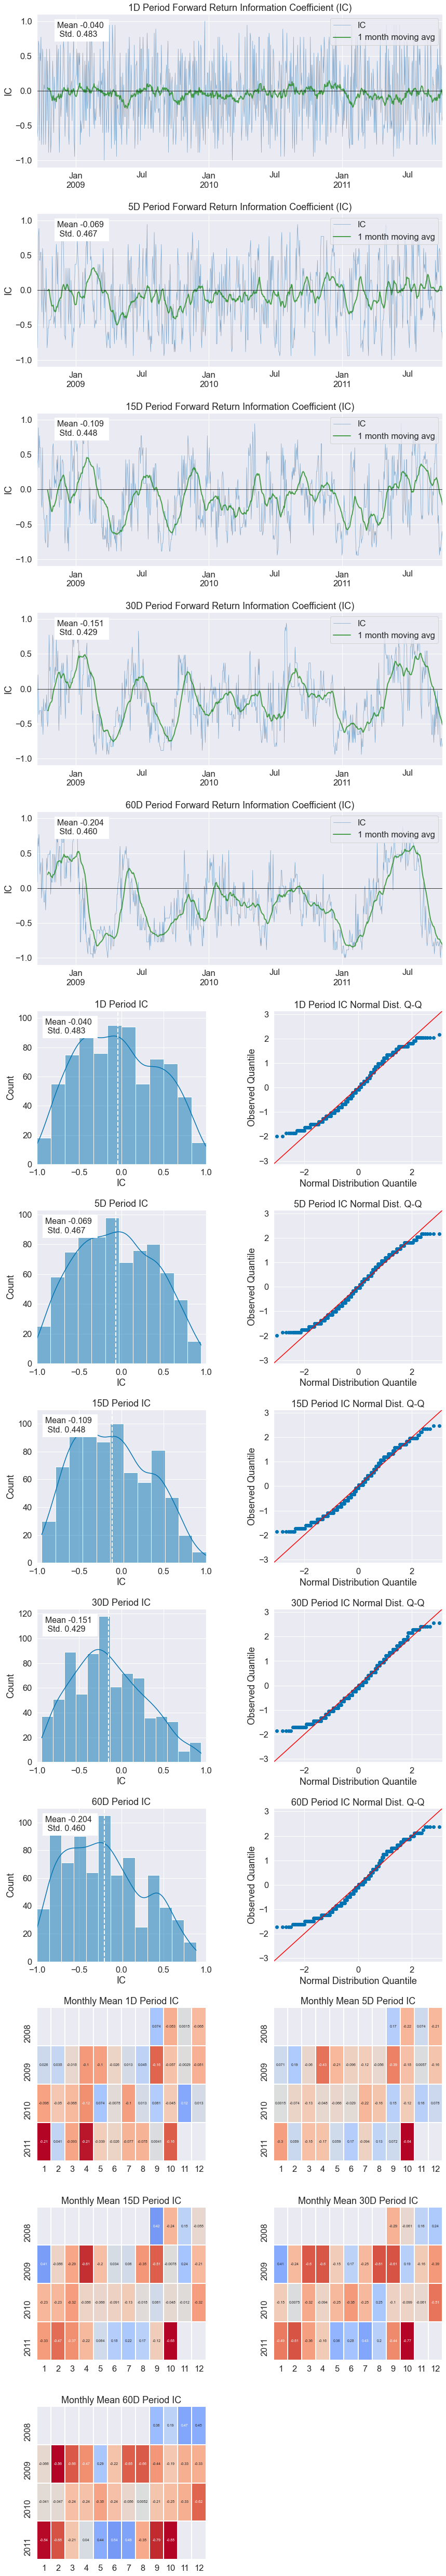

1D     5D    15D    30D    60D
Quantile 1 Mean Turnover   0.025  0.054  0.082  0.107  0.112
Quantile 2 Mean Turnover   0.049  0.107  0.164  0.214  0.224
Quantile 3 Mean Turnover   0.068  0.153  0.216  0.293  0.323
Quantile 4 Mean Turnover   0.183  0.324  0.445  0.586  0.623
Quantile 5 Mean Turnover   0.134  0.241  0.347  0.464  0.554

1D     5D    15D    30D    60D
Mean Factor Rank Autocorrelation  0.979  0.955  0.933  0.909  0.892

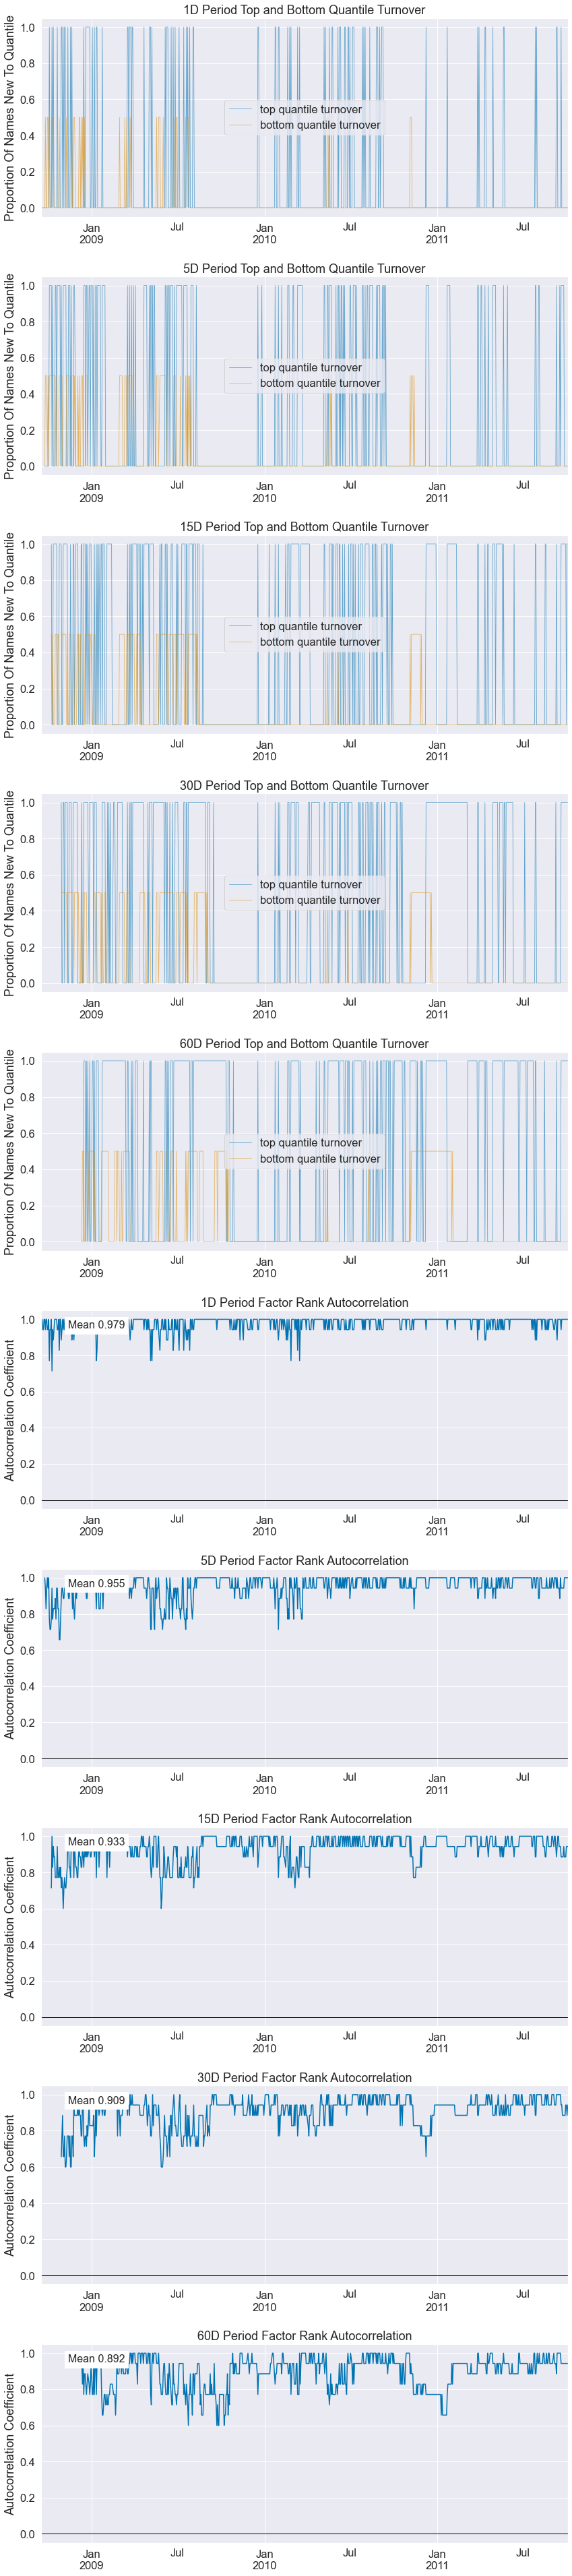

In [64]:
from alphalens.tears import create_full_tear_sheet
alphalens.tears.create_full_tear_sheet(alpha_data, long_short=True, group_neutral=False, by_group=False)